In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_precision
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
selected_classes = [3, 4, 7]
pickle_dir = 'pickles'
pytorch_chkpt_dir = 'pt-saves'
pretrained_model_path = f"{pytorch_chkpt_dir}/mnist_pt.pth"

In [3]:
# create folder if not exists
os.makedirs(pickle_dir, exist_ok=True)
os.makedirs(pytorch_chkpt_dir, exist_ok=True)

In [4]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (MNIST images are 28x28)
        self.fc2 = nn.Linear(128, 64)     # Hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes for MNIST digits)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)  # Output layer
        return x

In [5]:
# def train_model(model, train_loader, num_epochs=20, fine_tuning=False):
#     # Loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     # Set the model to training mode
#     model.train()
#     # Training loop
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         # Create a progress bar for the current epoch
#         with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
#             for inputs, labels in train_loader:
#                 # Zero the gradients
#                 optimizer.zero_grad()
#                 # Forward pass
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 # Backward pass and optimization
#                 loss.backward()
#                 optimizer.step()
#                 # Track the running loss
#                 running_loss += loss.item()
#                 # Update the progress bar
#                 pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
#                 pbar.update(1)
#     if fine_tuning:
#         print("Fine-tuning complete!")
#     else:
#         print("Training complete!")

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, num_epochs=20, fine_tuning=False):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize lists to track metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Set the model to training mode
        model.train()
        
        # Create a progress bar for the current epoch
        with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, labels in train_loader:
                # Zero the gradients
                optimizer.zero_grad()
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                # Track the running loss
                running_loss += loss.item()
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                # Update the progress bar
                pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Evaluate on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    if fine_tuning:
        print("Fine-tuning complete!")
    else:
        print("Training complete!")

    # Plot the metrics
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [10]:
def load_from_pickle(pickle_name):
    pickled_data = pickle.load(open(f"{pickle_dir}/{pickle_name}", "rb"))
    return DataLoader(pickled_data, batch_size=32, shuffle=True)

In [11]:
def load_pretrained_model():
    model_pt = SimpleNN()
    mnist_pt = torch.load(pretrained_model_path)
    model_pt.load_state_dict(mnist_pt)
    return model_pt

In [12]:
def evaluate_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()
    # Initialize variables to track the predictions and true labels
    all_predictions = []
    all_labels = []
    # No gradients needed for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Forward pass: Get model predictions
            outputs = model(inputs)
            
            # Get the predicted class by finding the class with the highest score
            _, predicted = torch.max(outputs, 1)
            
            # Store the predictions and true labels for metric calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    cr = classification_report(all_labels, all_predictions)
    print(f'Classification report for tain data:\n{cr}')

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10)) 
    plt.title('Confusion Matrix') 
    plt.xlabel('Predicted') 
    plt.ylabel('True') 
    plt.show()

    # Confusion Matrix
    # conf_matrix = confusion_matrix(all_labels, all_predictions)

In [13]:
def plot_mnist_data(loader):
    images, labels = next(iter(loader))
    # Create a grid of images (8x8) for display
    grid = torchvision.utils.make_grid(images[:64], nrow=8, padding=2, normalize=True)
    # Display the images in a grid
    plt.figure(figsize=(4, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Rearrange dimensions for matplotlib (H x W x C)
    plt.axis('off')
    plt.title("Sample MNIST Images")
    plt.show()

## Part 1: Split Data

In [14]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

In [15]:
# Load the MNIST training and testing datasets
mnist_train = torchvision.datasets.MNIST(
    root='./data',  # Directory where the data will be stored
    train=True,     # Load the training dataset
    transform=transform,  # Apply the transformations
    download=True   # Download the dataset if not already present
)

In [16]:
mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,    # Load the test dataset
    transform=transform,
    download=True
)

In [17]:
selected = {}
remaining = []
for i in mnist_train:
    if i[1] in selected_classes:
        if i[1] not in selected:
            selected[i[1]] = []
        if len(selected[i[1]]) < 1000:
            selected[i[1]].append(i)
        else:
            remaining.append(i)
    else:
        remaining.append(i)

for sc in selected:
    print(f"Class {sc} has {len(selected[sc])} samples")
    # write training datasets for fine-tuning to pickles
    pickle.dump(selected[sc], open(f"{pickle_dir}/train_{sc}.pkl", "wb"))
# write remaining dataset to separate pickle as well
print(f"Remaining list has {len(remaining)} samples")
pickle.dump(remaining, open(f"{pickle_dir}/train_rem.pkl", "wb"))

Class 4 has 1000 samples
Class 3 has 1000 samples
Class 7 has 1000 samples
Remaining list has 57000 samples


## Part 2: Train Model as Pretrained and Computation of its Functional Metrics

In [18]:
# load the data from pickle
train_loader = load_from_pickle("train_rem.pkl")
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=True)

Epoch [1/55]: 100%|██████████| 1782/1782 [00:07<00:00, 224.01batch/s, Loss=0.3584]


Epoch [1/55] - Train Loss: 0.3584, Train Acc: 0.8912, Test Loss: 0.1917, Test Acc: 0.9418


Epoch [2/55]: 100%|██████████| 1782/1782 [00:07<00:00, 238.87batch/s, Loss=0.1756]


Epoch [2/55] - Train Loss: 0.1756, Train Acc: 0.9471, Test Loss: 0.1338, Test Acc: 0.9557


Epoch [3/55]: 100%|██████████| 1782/1782 [00:07<00:00, 245.09batch/s, Loss=0.1314]


Epoch [3/55] - Train Loss: 0.1314, Train Acc: 0.9593, Test Loss: 0.1373, Test Acc: 0.9592


Epoch [4/55]: 100%|██████████| 1782/1782 [00:07<00:00, 247.31batch/s, Loss=0.1080]


Epoch [4/55] - Train Loss: 0.1080, Train Acc: 0.9661, Test Loss: 0.1290, Test Acc: 0.9592


Epoch [5/55]: 100%|██████████| 1782/1782 [00:07<00:00, 242.21batch/s, Loss=0.0951]


Epoch [5/55] - Train Loss: 0.0951, Train Acc: 0.9703, Test Loss: 0.1146, Test Acc: 0.9615


Epoch [6/55]: 100%|██████████| 1782/1782 [00:08<00:00, 220.25batch/s, Loss=0.0816]


Epoch [6/55] - Train Loss: 0.0816, Train Acc: 0.9737, Test Loss: 0.0990, Test Acc: 0.9692


Epoch [7/55]: 100%|██████████| 1782/1782 [00:08<00:00, 206.34batch/s, Loss=0.0728]


Epoch [7/55] - Train Loss: 0.0728, Train Acc: 0.9768, Test Loss: 0.1006, Test Acc: 0.9716


Epoch [8/55]: 100%|██████████| 1782/1782 [00:07<00:00, 239.16batch/s, Loss=0.0658]


Epoch [8/55] - Train Loss: 0.0658, Train Acc: 0.9785, Test Loss: 0.1125, Test Acc: 0.9679


Epoch [9/55]: 100%|██████████| 1782/1782 [00:07<00:00, 227.98batch/s, Loss=0.0614]


Epoch [9/55] - Train Loss: 0.0614, Train Acc: 0.9798, Test Loss: 0.1107, Test Acc: 0.9676


Epoch [10/55]: 100%|██████████| 1782/1782 [00:07<00:00, 225.63batch/s, Loss=0.0572]


Epoch [10/55] - Train Loss: 0.0572, Train Acc: 0.9806, Test Loss: 0.1197, Test Acc: 0.9652


Epoch [11/55]: 100%|██████████| 1782/1782 [00:07<00:00, 223.15batch/s, Loss=0.0526]


Epoch [11/55] - Train Loss: 0.0526, Train Acc: 0.9823, Test Loss: 0.0921, Test Acc: 0.9748


Epoch [12/55]: 100%|██████████| 1782/1782 [00:08<00:00, 207.16batch/s, Loss=0.0504]


Epoch [12/55] - Train Loss: 0.0504, Train Acc: 0.9829, Test Loss: 0.1015, Test Acc: 0.9738


Epoch [13/55]: 100%|██████████| 1782/1782 [00:08<00:00, 220.78batch/s, Loss=0.0469]


Epoch [13/55] - Train Loss: 0.0469, Train Acc: 0.9843, Test Loss: 0.1081, Test Acc: 0.9700


Epoch [14/55]: 100%|██████████| 1782/1782 [00:09<00:00, 194.30batch/s, Loss=0.0435]


Epoch [14/55] - Train Loss: 0.0435, Train Acc: 0.9860, Test Loss: 0.0955, Test Acc: 0.9735


Epoch [15/55]: 100%|██████████| 1782/1782 [00:07<00:00, 246.29batch/s, Loss=0.0414]


Epoch [15/55] - Train Loss: 0.0414, Train Acc: 0.9860, Test Loss: 0.1076, Test Acc: 0.9713


Epoch [16/55]: 100%|██████████| 1782/1782 [00:07<00:00, 238.14batch/s, Loss=0.0416]


Epoch [16/55] - Train Loss: 0.0416, Train Acc: 0.9853, Test Loss: 0.1171, Test Acc: 0.9705


Epoch [17/55]: 100%|██████████| 1782/1782 [00:07<00:00, 249.46batch/s, Loss=0.0399]


Epoch [17/55] - Train Loss: 0.0399, Train Acc: 0.9866, Test Loss: 0.1066, Test Acc: 0.9724


Epoch [18/55]: 100%|██████████| 1782/1782 [00:07<00:00, 235.78batch/s, Loss=0.0369]


Epoch [18/55] - Train Loss: 0.0369, Train Acc: 0.9876, Test Loss: 0.1217, Test Acc: 0.9726


Epoch [19/55]: 100%|██████████| 1782/1782 [00:09<00:00, 191.70batch/s, Loss=0.0342]


Epoch [19/55] - Train Loss: 0.0342, Train Acc: 0.9886, Test Loss: 0.1191, Test Acc: 0.9741


Epoch [20/55]: 100%|██████████| 1782/1782 [00:16<00:00, 109.80batch/s, Loss=0.0382]


Epoch [20/55] - Train Loss: 0.0382, Train Acc: 0.9877, Test Loss: 0.1095, Test Acc: 0.9689


Epoch [21/55]: 100%|██████████| 1782/1782 [00:14<00:00, 119.80batch/s, Loss=0.0301]


Epoch [21/55] - Train Loss: 0.0301, Train Acc: 0.9897, Test Loss: 0.1191, Test Acc: 0.9740


Epoch [22/55]: 100%|██████████| 1782/1782 [00:10<00:00, 178.08batch/s, Loss=0.0319]


Epoch [22/55] - Train Loss: 0.0319, Train Acc: 0.9893, Test Loss: 0.1225, Test Acc: 0.9742


Epoch [23/55]: 100%|██████████| 1782/1782 [00:08<00:00, 202.28batch/s, Loss=0.0284]


Epoch [23/55] - Train Loss: 0.0284, Train Acc: 0.9899, Test Loss: 0.1295, Test Acc: 0.9705


Epoch [24/55]: 100%|██████████| 1782/1782 [00:10<00:00, 174.10batch/s, Loss=0.0307]


Epoch [24/55] - Train Loss: 0.0307, Train Acc: 0.9898, Test Loss: 0.1395, Test Acc: 0.9731


Epoch [25/55]: 100%|██████████| 1782/1782 [00:08<00:00, 218.20batch/s, Loss=0.0297]


Epoch [25/55] - Train Loss: 0.0297, Train Acc: 0.9903, Test Loss: 0.1531, Test Acc: 0.9642


Epoch [26/55]: 100%|██████████| 1782/1782 [00:07<00:00, 239.51batch/s, Loss=0.0294]


Epoch [26/55] - Train Loss: 0.0294, Train Acc: 0.9906, Test Loss: 0.1606, Test Acc: 0.9676


Epoch [27/55]: 100%|██████████| 1782/1782 [00:07<00:00, 239.81batch/s, Loss=0.0267]


Epoch [27/55] - Train Loss: 0.0267, Train Acc: 0.9911, Test Loss: 0.1307, Test Acc: 0.9747


Epoch [28/55]: 100%|██████████| 1782/1782 [00:07<00:00, 240.82batch/s, Loss=0.0264]


Epoch [28/55] - Train Loss: 0.0264, Train Acc: 0.9910, Test Loss: 0.1536, Test Acc: 0.9724


Epoch [29/55]: 100%|██████████| 1782/1782 [00:07<00:00, 235.64batch/s, Loss=0.0253]


Epoch [29/55] - Train Loss: 0.0253, Train Acc: 0.9914, Test Loss: 0.1528, Test Acc: 0.9740


Epoch [30/55]: 100%|██████████| 1782/1782 [00:07<00:00, 245.99batch/s, Loss=0.0295]


Epoch [30/55] - Train Loss: 0.0295, Train Acc: 0.9903, Test Loss: 0.1406, Test Acc: 0.9740


Epoch [31/55]: 100%|██████████| 1782/1782 [00:07<00:00, 233.52batch/s, Loss=0.0248]


Epoch [31/55] - Train Loss: 0.0248, Train Acc: 0.9922, Test Loss: 0.1431, Test Acc: 0.9742


Epoch [32/55]: 100%|██████████| 1782/1782 [00:07<00:00, 242.35batch/s, Loss=0.0244]


Epoch [32/55] - Train Loss: 0.0244, Train Acc: 0.9923, Test Loss: 0.1853, Test Acc: 0.9717


Epoch [33/55]: 100%|██████████| 1782/1782 [00:07<00:00, 244.74batch/s, Loss=0.0249]


Epoch [33/55] - Train Loss: 0.0249, Train Acc: 0.9922, Test Loss: 0.1345, Test Acc: 0.9757


Epoch [34/55]: 100%|██████████| 1782/1782 [00:07<00:00, 241.82batch/s, Loss=0.0246]


Epoch [34/55] - Train Loss: 0.0246, Train Acc: 0.9923, Test Loss: 0.1422, Test Acc: 0.9746


Epoch [35/55]: 100%|██████████| 1782/1782 [00:07<00:00, 229.63batch/s, Loss=0.0238]


Epoch [35/55] - Train Loss: 0.0238, Train Acc: 0.9925, Test Loss: 0.1281, Test Acc: 0.9772


Epoch [36/55]: 100%|██████████| 1782/1782 [00:07<00:00, 240.08batch/s, Loss=0.0233]


Epoch [36/55] - Train Loss: 0.0233, Train Acc: 0.9923, Test Loss: 0.1576, Test Acc: 0.9712


Epoch [37/55]: 100%|██████████| 1782/1782 [00:08<00:00, 201.48batch/s, Loss=0.0215]


Epoch [37/55] - Train Loss: 0.0215, Train Acc: 0.9934, Test Loss: 0.1675, Test Acc: 0.9720


Epoch [38/55]: 100%|██████████| 1782/1782 [00:09<00:00, 185.76batch/s, Loss=0.0230]


Epoch [38/55] - Train Loss: 0.0230, Train Acc: 0.9926, Test Loss: 0.1676, Test Acc: 0.9717


Epoch [39/55]: 100%|██████████| 1782/1782 [00:08<00:00, 204.15batch/s, Loss=0.0192]


Epoch [39/55] - Train Loss: 0.0192, Train Acc: 0.9935, Test Loss: 0.1564, Test Acc: 0.9744


Epoch [40/55]: 100%|██████████| 1782/1782 [00:07<00:00, 236.00batch/s, Loss=0.0242]


Epoch [40/55] - Train Loss: 0.0242, Train Acc: 0.9928, Test Loss: 0.1687, Test Acc: 0.9718


Epoch [41/55]: 100%|██████████| 1782/1782 [00:08<00:00, 218.26batch/s, Loss=0.0214]


Epoch [41/55] - Train Loss: 0.0214, Train Acc: 0.9931, Test Loss: 0.1772, Test Acc: 0.9724


Epoch [42/55]: 100%|██████████| 1782/1782 [00:07<00:00, 224.92batch/s, Loss=0.0239]


Epoch [42/55] - Train Loss: 0.0239, Train Acc: 0.9931, Test Loss: 0.1566, Test Acc: 0.9701


Epoch [43/55]: 100%|██████████| 1782/1782 [00:07<00:00, 227.52batch/s, Loss=0.0185]


Epoch [43/55] - Train Loss: 0.0185, Train Acc: 0.9942, Test Loss: 0.2017, Test Acc: 0.9721


Epoch [44/55]: 100%|██████████| 1782/1782 [00:07<00:00, 238.88batch/s, Loss=0.0217]


Epoch [44/55] - Train Loss: 0.0217, Train Acc: 0.9934, Test Loss: 0.1474, Test Acc: 0.9751


Epoch [45/55]: 100%|██████████| 1782/1782 [00:07<00:00, 233.75batch/s, Loss=0.0199]


Epoch [45/55] - Train Loss: 0.0199, Train Acc: 0.9938, Test Loss: 0.1663, Test Acc: 0.9741


Epoch [46/55]: 100%|██████████| 1782/1782 [00:07<00:00, 235.11batch/s, Loss=0.0217]


Epoch [46/55] - Train Loss: 0.0217, Train Acc: 0.9934, Test Loss: 0.1799, Test Acc: 0.9720


Epoch [47/55]: 100%|██████████| 1782/1782 [00:07<00:00, 238.58batch/s, Loss=0.0204]


Epoch [47/55] - Train Loss: 0.0204, Train Acc: 0.9939, Test Loss: 0.1456, Test Acc: 0.9777


Epoch [48/55]: 100%|██████████| 1782/1782 [00:08<00:00, 222.59batch/s, Loss=0.0217]


Epoch [48/55] - Train Loss: 0.0217, Train Acc: 0.9936, Test Loss: 0.1432, Test Acc: 0.9776


Epoch [49/55]: 100%|██████████| 1782/1782 [00:08<00:00, 220.25batch/s, Loss=0.0193]


Epoch [49/55] - Train Loss: 0.0193, Train Acc: 0.9939, Test Loss: 0.1674, Test Acc: 0.9739


Epoch [50/55]: 100%|██████████| 1782/1782 [00:07<00:00, 234.49batch/s, Loss=0.0226]


Epoch [50/55] - Train Loss: 0.0226, Train Acc: 0.9932, Test Loss: 0.1807, Test Acc: 0.9724


Epoch [51/55]: 100%|██████████| 1782/1782 [00:07<00:00, 237.56batch/s, Loss=0.0182]


Epoch [51/55] - Train Loss: 0.0182, Train Acc: 0.9945, Test Loss: 0.1737, Test Acc: 0.9747


Epoch [52/55]: 100%|██████████| 1782/1782 [00:07<00:00, 232.14batch/s, Loss=0.0215]


Epoch [52/55] - Train Loss: 0.0215, Train Acc: 0.9932, Test Loss: 0.2069, Test Acc: 0.9716


Epoch [53/55]: 100%|██████████| 1782/1782 [00:07<00:00, 234.30batch/s, Loss=0.0175]


Epoch [53/55] - Train Loss: 0.0175, Train Acc: 0.9949, Test Loss: 0.1803, Test Acc: 0.9731


Epoch [54/55]: 100%|██████████| 1782/1782 [00:07<00:00, 235.04batch/s, Loss=0.0206]


Epoch [54/55] - Train Loss: 0.0206, Train Acc: 0.9943, Test Loss: 0.2009, Test Acc: 0.9695


Epoch [55/55]: 100%|██████████| 1782/1782 [00:07<00:00, 235.56batch/s, Loss=0.0209]


Epoch [55/55] - Train Loss: 0.0209, Train Acc: 0.9938, Test Loss: 0.1705, Test Acc: 0.9752
Training complete!


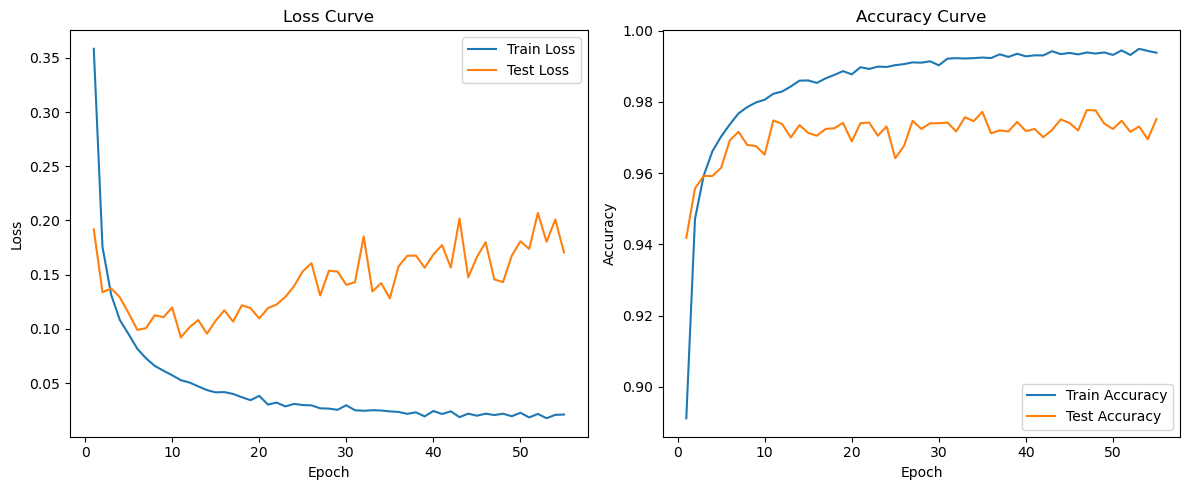

In [19]:
# Initialize the model
model = SimpleNN()
train_model(model, test_loader=test_loader, train_loader=train_loader, num_epochs=55)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.95      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.94      0.97      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



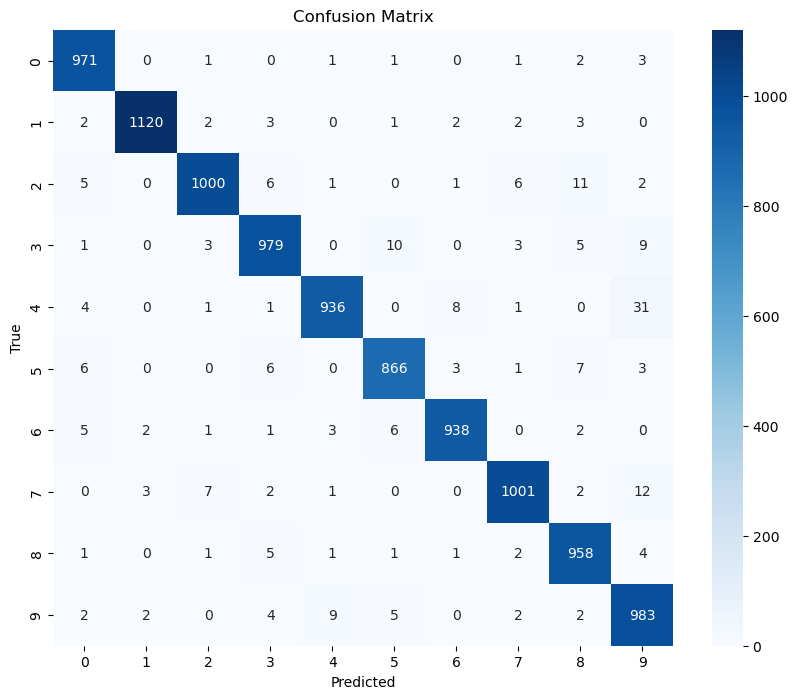

In [20]:
evaluate_model(model, test_loader)

In [21]:
# load the data from pickle
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")
# Initialize the model
# model_ft_3 = load_pretrained_model()

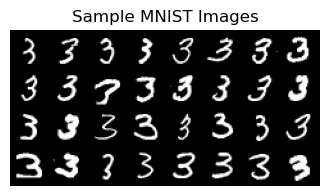

In [22]:
plot_mnist_data(train_loader_3)

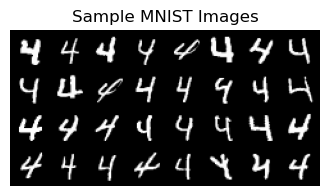

In [23]:
plot_mnist_data(train_loader_4)

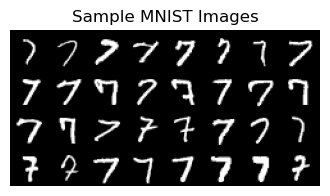

In [24]:
plot_mnist_data(train_loader_7)

Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 126.39batch/s, Loss=0.1045]


Epoch [1/10] - Train Loss: 0.1045, Train Acc: 0.9880, Test Loss: 1.4923, Test Acc: 0.8208


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 245.15batch/s, Loss=0.0000]


Epoch [2/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.4959, Test Acc: 0.6619


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 286.56batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.6442, Test Acc: 0.6549


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 293.17batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.6887, Test Acc: 0.6541


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 286.83batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.6475, Test Acc: 0.6540


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 292.45batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.6694, Test Acc: 0.6539


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 274.69batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.6448, Test Acc: 0.6535


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 283.00batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.6685, Test Acc: 0.6535


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 226.34batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.6765, Test Acc: 0.6534


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 239.39batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.6578, Test Acc: 0.6534
Fine-tuning complete!


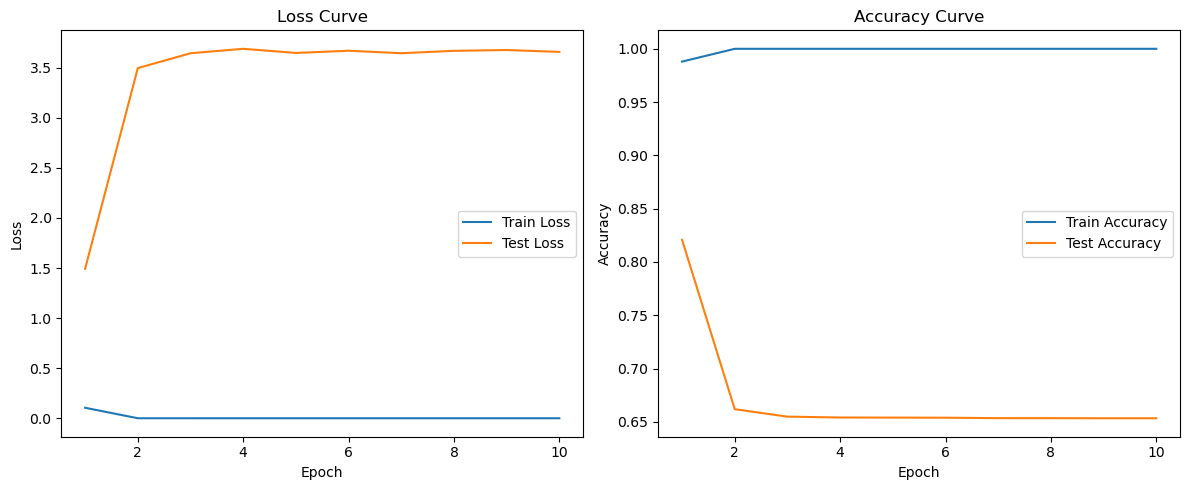

In [25]:
train_model(model, train_loader_3, test_loader=test_loader,num_epochs=10, fine_tuning=True)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       0.99      0.66      0.79      1135
           2       0.97      0.53      0.68      1032
           3       0.24      1.00      0.38      1010
           4       1.00      0.76      0.86       982
           5       0.97      0.57      0.72       892
           6       0.99      0.90      0.94       958
           7       0.99      0.19      0.31      1028
           8       0.93      0.61      0.74       974
           9       0.75      0.38      0.51      1009

    accuracy                           0.65     10000
   macro avg       0.88      0.66      0.69     10000
weighted avg       0.88      0.65      0.69     10000



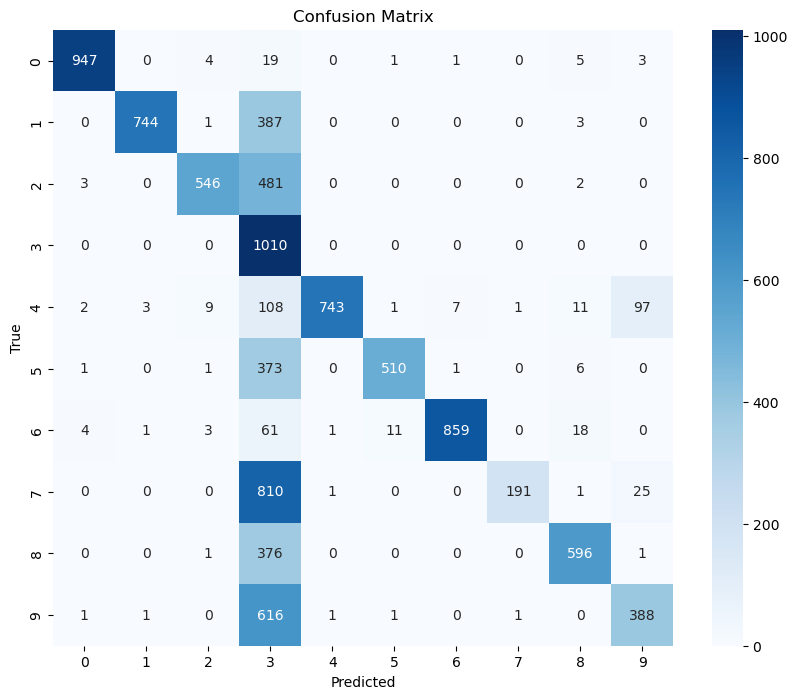

In [26]:
evaluate_model(model, test_loader)

Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 124.52batch/s, Loss=0.1790]


Epoch [1/10] - Train Loss: 0.1790, Train Acc: 0.9790, Test Loss: 1.1705, Test Acc: 0.8618


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 251.57batch/s, Loss=0.0003]


Epoch [2/10] - Train Loss: 0.0003, Train Acc: 1.0000, Test Loss: 1.3946, Test Acc: 0.8415


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 208.27batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.4033, Test Acc: 0.8405


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 198.72batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.4259, Test Acc: 0.8401


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 187.28batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.4249, Test Acc: 0.8401


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 149.50batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.4197, Test Acc: 0.8401


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 174.76batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.4122, Test Acc: 0.8397


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 188.19batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.4363, Test Acc: 0.8395


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 189.53batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.4380, Test Acc: 0.8395


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 192.40batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 1.4398, Test Acc: 0.8394
Fine-tuning complete!


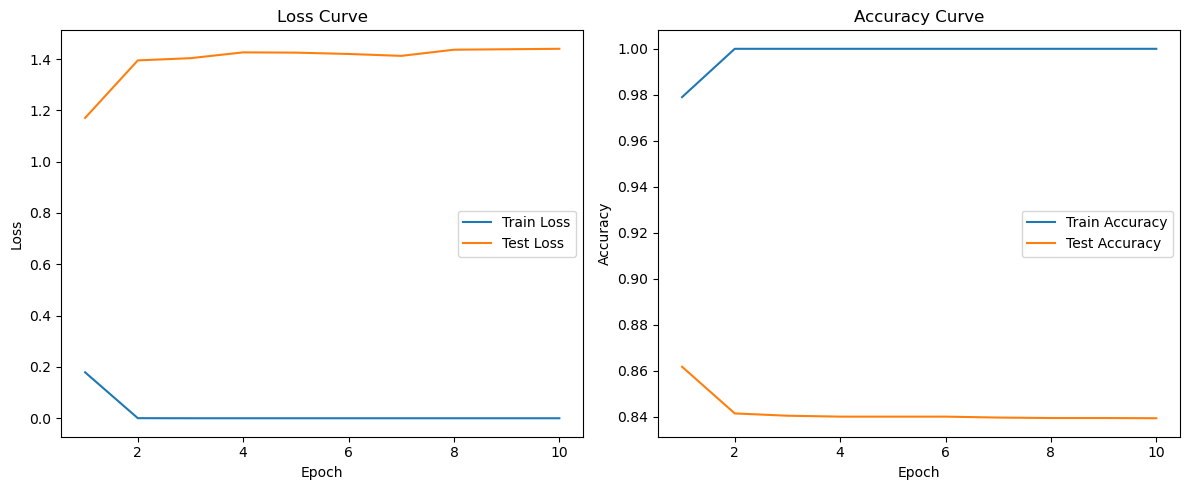

In [27]:
train_model(model, train_loader_4, test_loader=test_loader, num_epochs=10, fine_tuning=True )

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       980
           1       0.95      0.88      0.91      1135
           2       1.00      0.62      0.77      1032
           3       0.67      0.99      0.80      1010
           4       0.51      1.00      0.67       982
           5       0.98      0.79      0.88       892
           6       0.99      0.89      0.94       958
           7       0.97      0.90      0.93      1028
           8       0.95      0.85      0.90       974
           9       0.97      0.53      0.68      1009

    accuracy                           0.84     10000
   macro avg       0.90      0.84      0.85     10000
weighted avg       0.90      0.84      0.85     10000



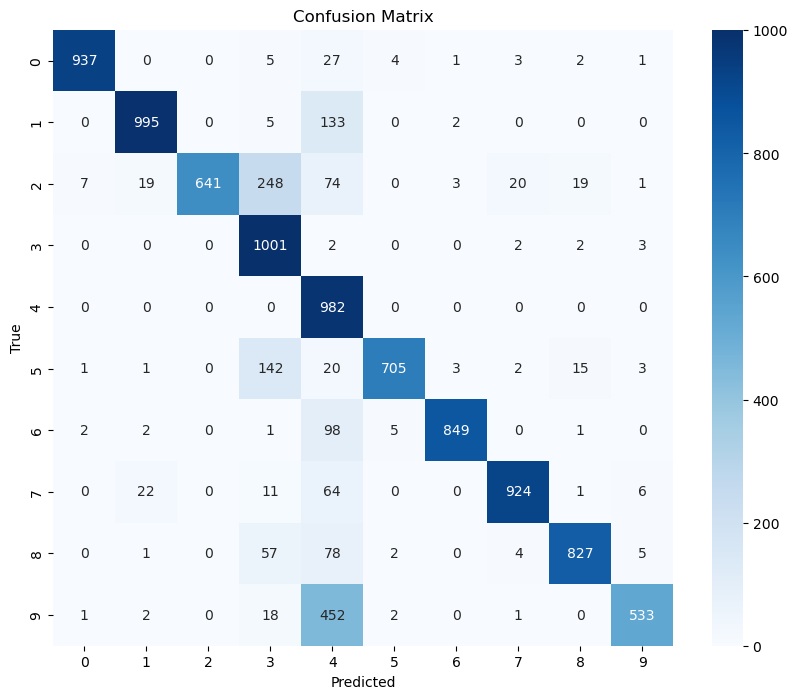

In [28]:
evaluate_model(model, test_loader)

Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 217.62batch/s, Loss=0.1150]


Epoch [1/5] - Train Loss: 0.1150, Train Acc: 0.9850, Test Loss: 2.6289, Test Acc: 0.7327


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 151.26batch/s, Loss=0.0000]


Epoch [2/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.7589, Test Acc: 0.6632


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 176.58batch/s, Loss=0.0000]


Epoch [3/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.8316, Test Acc: 0.6606


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 154.26batch/s, Loss=0.0000]


Epoch [4/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.8202, Test Acc: 0.6605


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 279.09batch/s, Loss=0.0000]


Epoch [5/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.8880, Test Acc: 0.6603
Fine-tuning complete!


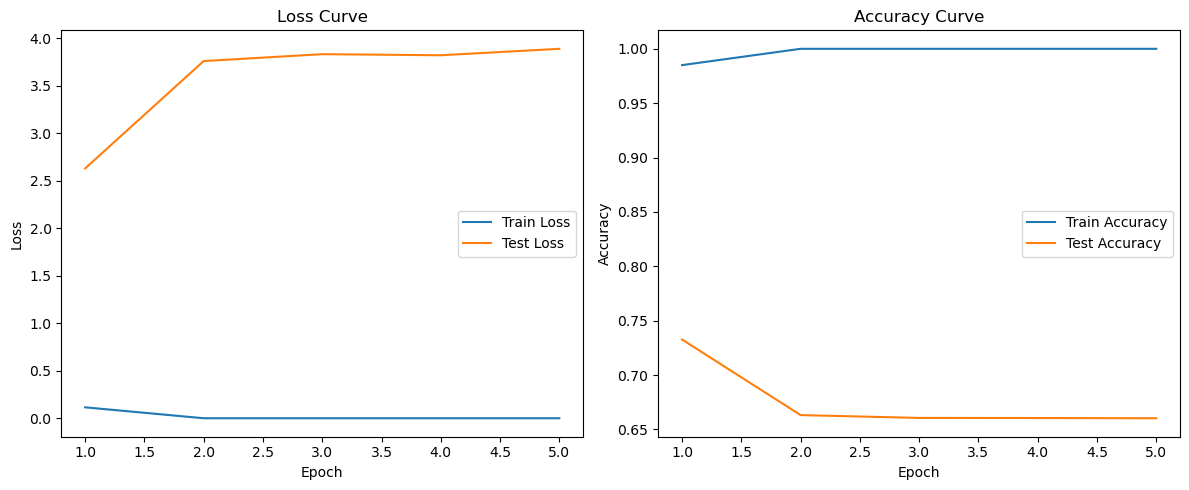

In [29]:
train_model(model, train_loader_7, test_loader=test_loader,num_epochs=5, fine_tuning=True)

Classification report for tain data:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       980
           1       0.96      0.26      0.41      1135
           2       0.99      0.37      0.54      1032
           3       0.58      0.94      0.72      1010
           4       0.77      0.87      0.82       982
           5       0.99      0.56      0.71       892
           6       0.99      0.78      0.88       958
           7       0.30      1.00      0.46      1028
           8       0.97      0.51      0.67       974
           9       0.95      0.46      0.62      1009

    accuracy                           0.66     10000
   macro avg       0.85      0.67      0.68     10000
weighted avg       0.85      0.66      0.67     10000



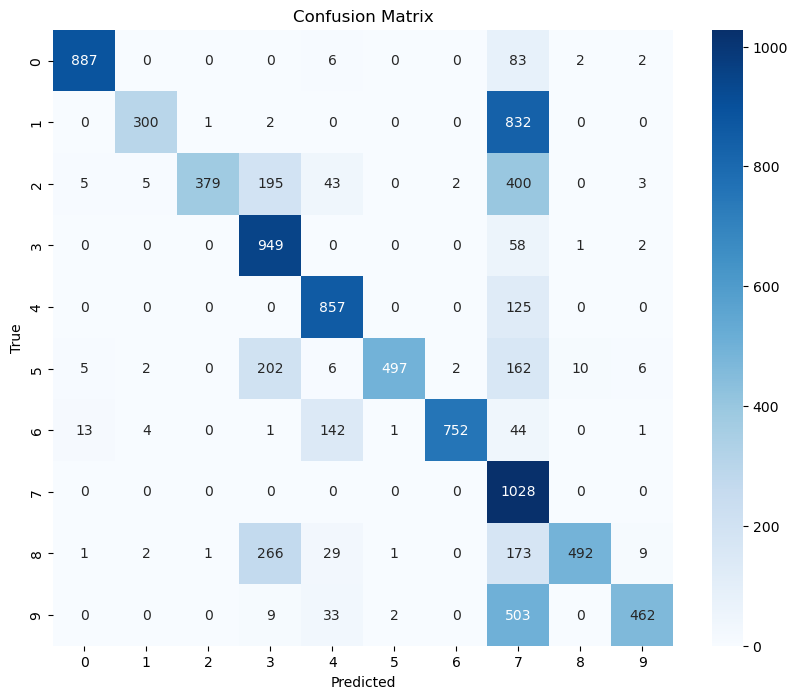

In [30]:
evaluate_model(model, test_loader)

In [31]:
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")

Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 144.44batch/s, Loss=0.1536]


Epoch [1/5] - Train Loss: 0.1536, Train Acc: 0.9900, Test Loss: 6.3949, Test Acc: 0.5339


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 272.72batch/s, Loss=0.0001]


Epoch [2/5] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 7.3960, Test Acc: 0.4992


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 271.48batch/s, Loss=0.0000]


Epoch [3/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 7.5059, Test Acc: 0.4963


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 229.37batch/s, Loss=0.0000]


Epoch [4/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 7.5045, Test Acc: 0.4957


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 269.71batch/s, Loss=0.0000]


Epoch [5/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 7.5401, Test Acc: 0.4952
Fine-tuning complete!


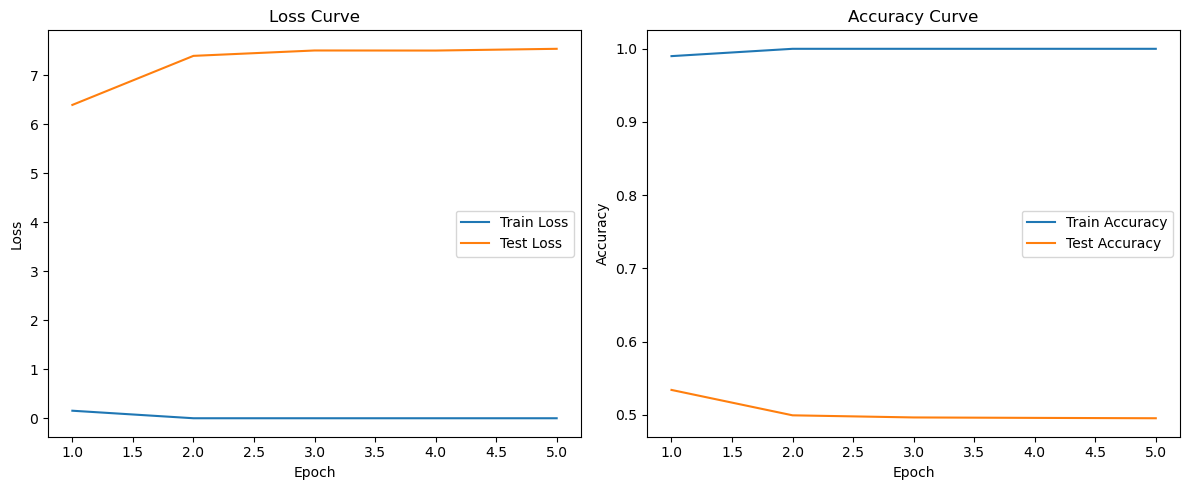

Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 292.41batch/s, Loss=0.0824]


Epoch [1/5] - Train Loss: 0.0824, Train Acc: 0.9810, Test Loss: 3.0813, Test Acc: 0.7127


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 258.83batch/s, Loss=0.0000]


Epoch [2/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.2973, Test Acc: 0.7004


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 298.88batch/s, Loss=0.0000]


Epoch [3/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.2733, Test Acc: 0.7001


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 298.92batch/s, Loss=0.0000]


Epoch [4/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.2750, Test Acc: 0.6997


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 271.94batch/s, Loss=0.0000]


Epoch [5/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.3052, Test Acc: 0.6996
Fine-tuning complete!


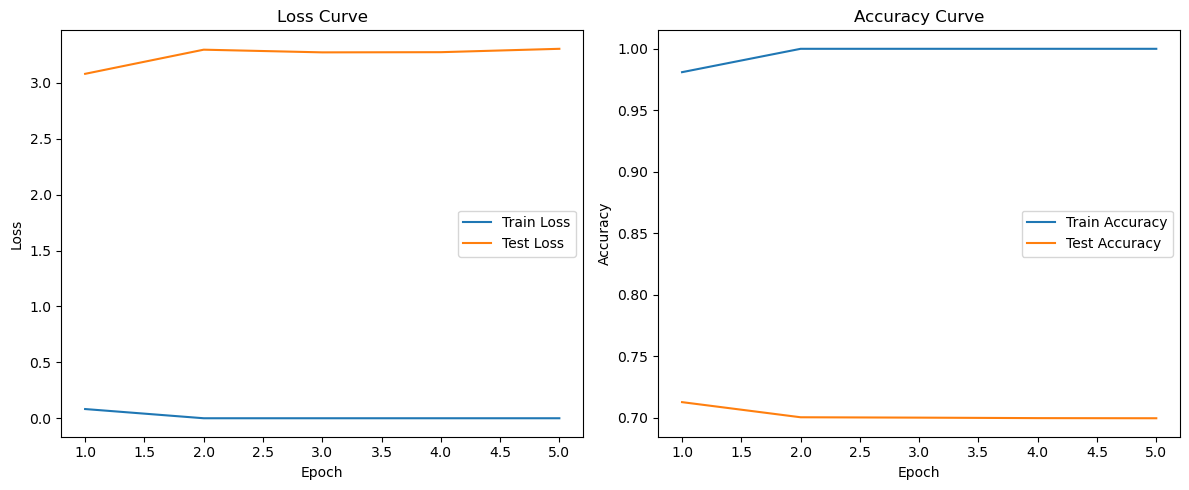

Epoch [1/5]: 100%|██████████| 32/32 [00:00<00:00, 274.15batch/s, Loss=0.1052]


Epoch [1/5] - Train Loss: 0.1052, Train Acc: 0.9880, Test Loss: 3.8524, Test Acc: 0.6409


Epoch [2/5]: 100%|██████████| 32/32 [00:00<00:00, 281.90batch/s, Loss=0.0000]


Epoch [2/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.3722, Test Acc: 0.6212


Epoch [3/5]: 100%|██████████| 32/32 [00:00<00:00, 269.68batch/s, Loss=0.0000]


Epoch [3/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.4549, Test Acc: 0.6168


Epoch [4/5]: 100%|██████████| 32/32 [00:00<00:00, 289.90batch/s, Loss=0.0000]


Epoch [4/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.4485, Test Acc: 0.6157


Epoch [5/5]: 100%|██████████| 32/32 [00:00<00:00, 250.13batch/s, Loss=0.0000]


Epoch [5/5] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.4749, Test Acc: 0.6153
Fine-tuning complete!


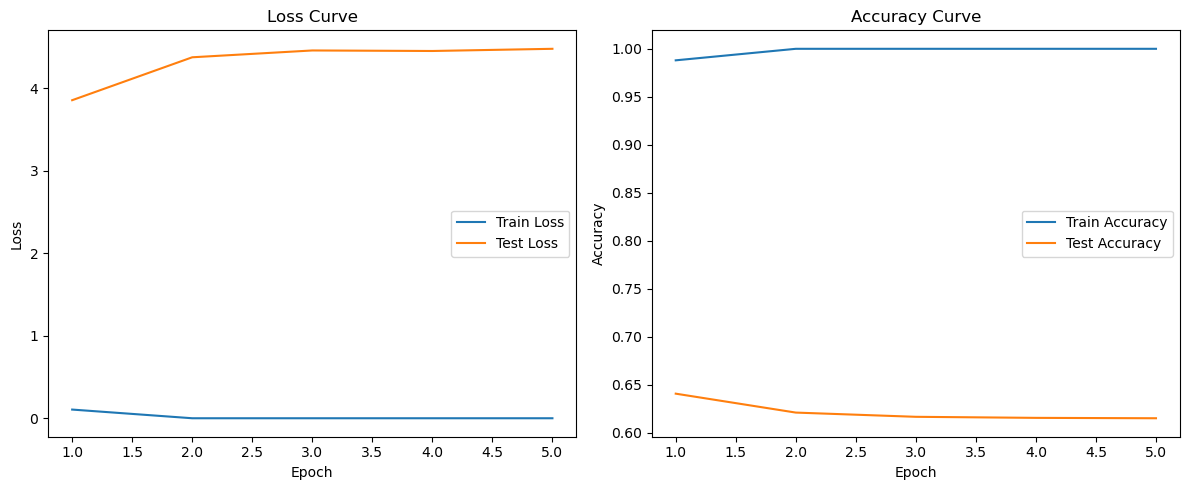

In [32]:
train_model(model, train_loader_3, test_loader=test_loader, num_epochs=5, fine_tuning=True)
train_model(model, train_loader_4, test_loader=test_loader, num_epochs=5, fine_tuning=True)
train_model(model, train_loader_7, test_loader=test_loader, num_epochs=5, fine_tuning=True)


Classification report for tain data:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       980
           1       0.95      0.21      0.35      1135
           2       0.99      0.37      0.54      1032
           3       0.53      0.96      0.68      1010
           4       0.73      0.83      0.77       982
           5       0.96      0.63      0.76       892
           6       1.00      0.80      0.89       958
           7       0.28      1.00      0.44      1028
           8       0.99      0.34      0.51       974
           9       0.97      0.15      0.27      1009

    accuracy                           0.62     10000
   macro avg       0.84      0.62      0.62     10000
weighted avg       0.84      0.62      0.61     10000



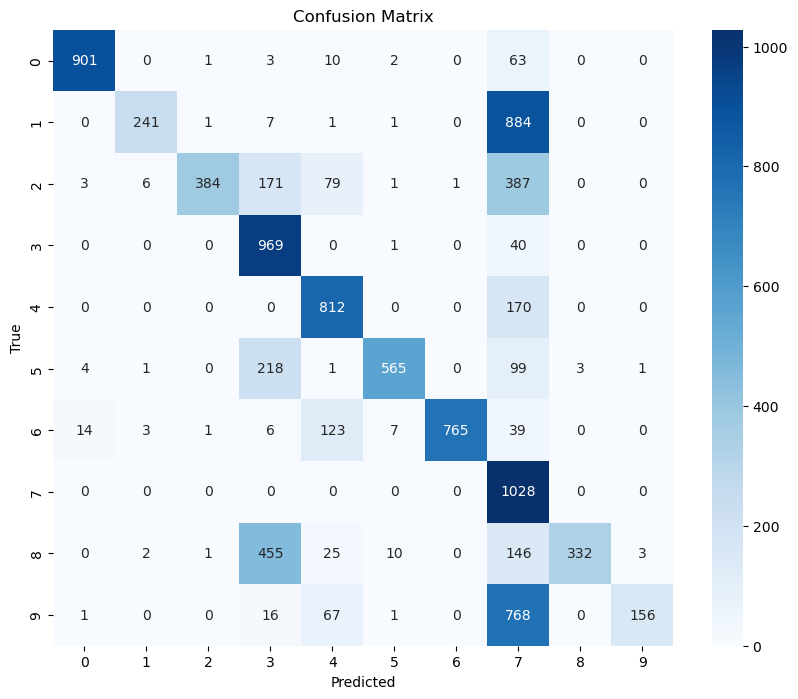

In [33]:
evaluate_model(model, test_loader)

In [34]:
# Save the model
torch.save(model.state_dict(), pretrained_model_path)
print("Model saved successfully!")

Model saved successfully!
